## Imports

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import collections
import scipy
import community


%matplotlib inline

## Loading the datasets

In [3]:
routes = pd.read_csv('routes.dat', header=None)

routes.columns = ['Airline','Airline ID',
                'Source airport',
                'Source airport ID',
                'Destination airport',
                'Destination airport ID',
                'Codeshare',
                'Stops',
                'Equipment']

In [4]:
routes.head()

,Airline,Airline ID,Source airport,Source airport ID,Destination airport,Destination airport ID,Codeshare,Stops,Equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [5]:
airports = pd.read_csv(
    'airports.dat',
    header=None,
    index_col=4,
    na_values='\\N')
airports.columns = ['Airport ID',
                    'Name',
                    'City',
                    'Country',
                    'ICAO',
                    'Latitude',
                    'Longitude',
                    'Altitude',
                    'Timezone',
                    'DST',
                    'TZ',
                    'Type',
                    'Source']

In [6]:
airports.head()

,Airport ID,Name,City,Country,ICAO,Latitude,Longitude,Altitude,Timezone,DST,TZ,Type,Source
4,,,,,,,,,,,,,
GKA,1,Goroka Airport,Goroka,Papua New Guinea,AYGA,-6.081690,145.391998,5282,10.0,U,Pacific/Port_Moresby,airport,OurAirports
MAG,2,Madang Airport,Madang,Papua New Guinea,AYMD,-5.207080,145.789001,20,10.0,U,Pacific/Port_Moresby,airport,OurAirports
HGU,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,AYMH,-5.826790,144.296005,5388,10.0,U,Pacific/Port_Moresby,airport,OurAirports
LAE,4,Nadzab Airport,Nadzab,Papua New Guinea,AYNZ,-6.569803,146.725977,239,10.0,U,Pacific/Port_Moresby,airport,OurAirports
POM,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,AYPY,-9.443380,147.220001,146,10.0,U,Pacific/Port_Moresby,airport,OurAirports


## Cleaning

In [10]:
airports_route = list(set(set(routes['Source airport']) | set(routes['Destination airport'])))

In [11]:
airports_air = list(airports.index)

In [12]:
nodes = list(set(airports_air) & set(airports_route))

In [13]:
routes_clean = routes[(routes['Source airport'].isin(nodes)) & (routes['Destination airport'].isin(nodes))]

In [14]:
airports_clean = airports[airports.index.isin(nodes)]

In [15]:
routes_clean['Source latitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Source airport ID'])].Latitude.values.item(0), axis = 1)
routes_clean['Source longitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Source airport ID'])].Longitude.values.item(0), axis = 1)
routes_clean['Destination latitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Destination airport ID'])].Latitude.values.item(0), axis = 1)
routes_clean['Destination longitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Destination airport ID'])].Longitude.values.item(0), axis = 1)

/home/adirlou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/adirlou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/adirlou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [17]:
routes_clean['Distance'] = routes_clean.apply(lambda row : geodesic((row['Source latitude'], row['Source longitude']), (row['Destination latitude'], row['Destination longitude'])).kilometers, axis = 1)

/home/adirlou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
routes_clean.head()

,Airline,Airline ID,Source airport,Source airport ID,Destination airport,Destination airport ID,Codeshare,Stops,Equipment,Source latitude,Source longitude,Destination latitude,Destination longitude,Distance
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2,43.449902,39.956600,55.606201,49.278702,1507.989717
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2,46.283298,48.006302,55.606201,49.278702,1040.943207
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2,46.283298,48.006302,44.225101,43.081902,449.036664
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2,55.305801,61.503300,55.606201,49.278702,773.126239
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2,55.305801,61.503300,55.012600,82.650703,1343.161122


**Save the clean data**

In [19]:
routes_clean.to_csv('routes_clean.csv', index=False)
airports_clean.to_csv('airports_clean.csv')

## World map

**Load clean data**

In [2]:
routes = pd.read_csv('routes_clean.csv', low_memory=False)

In [3]:
airports = pd.read_csv('airports_clean.csv', index_col=0)

**Get edges from routes and create graph**

In [4]:
G = nx.from_pandas_edgelist(routes, 'Source airport', 'Destination airport', ['Distance'])

/home/adirlou/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


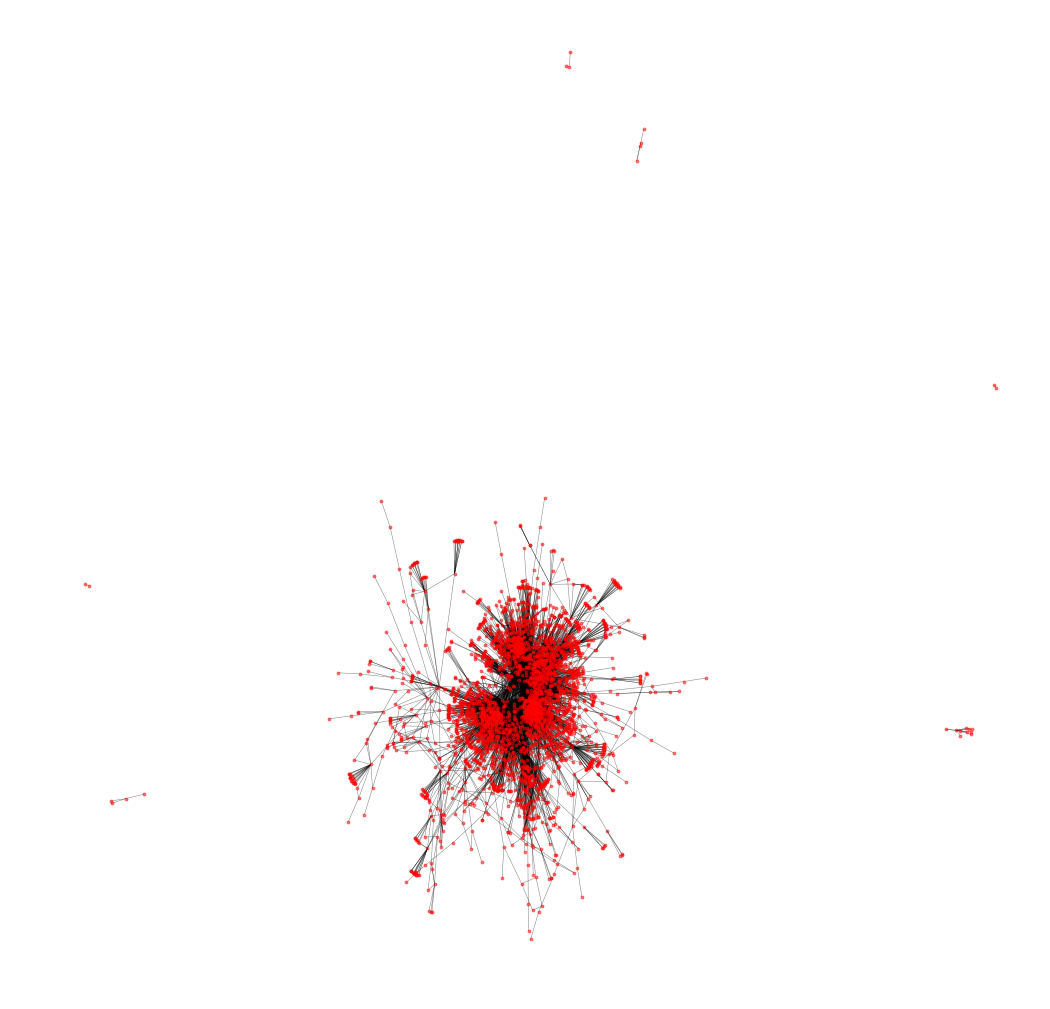

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(18, 18))
nx.draw_networkx(G, ax=ax, node_size=8, alpha=.5,
                 width=.5, with_labels=False)
ax.set_axis_off()

Get largest connected component for the rest

In [7]:
largest_cc = max(nx.connected_component_subgraphs(G), key=len)

To create the map, we first retrieve the coordinates from the airports dataframe

In [6]:
pos = {airport: (v['Longitude'], v['Latitude'])
       for airport, v in
       airports.to_dict('index').items()}

Node size will be the degree of the nodes

In [7]:
deg = nx.degree(largest_cc)
sizes = [5 * deg[iata] for iata in largest_cc.nodes]

Display label only if degree is quite big

In [8]:
labels = {iata: iata if deg[iata] >= 200 else ''
          for iata in largest_cc.nodes}

/home/adirlou/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


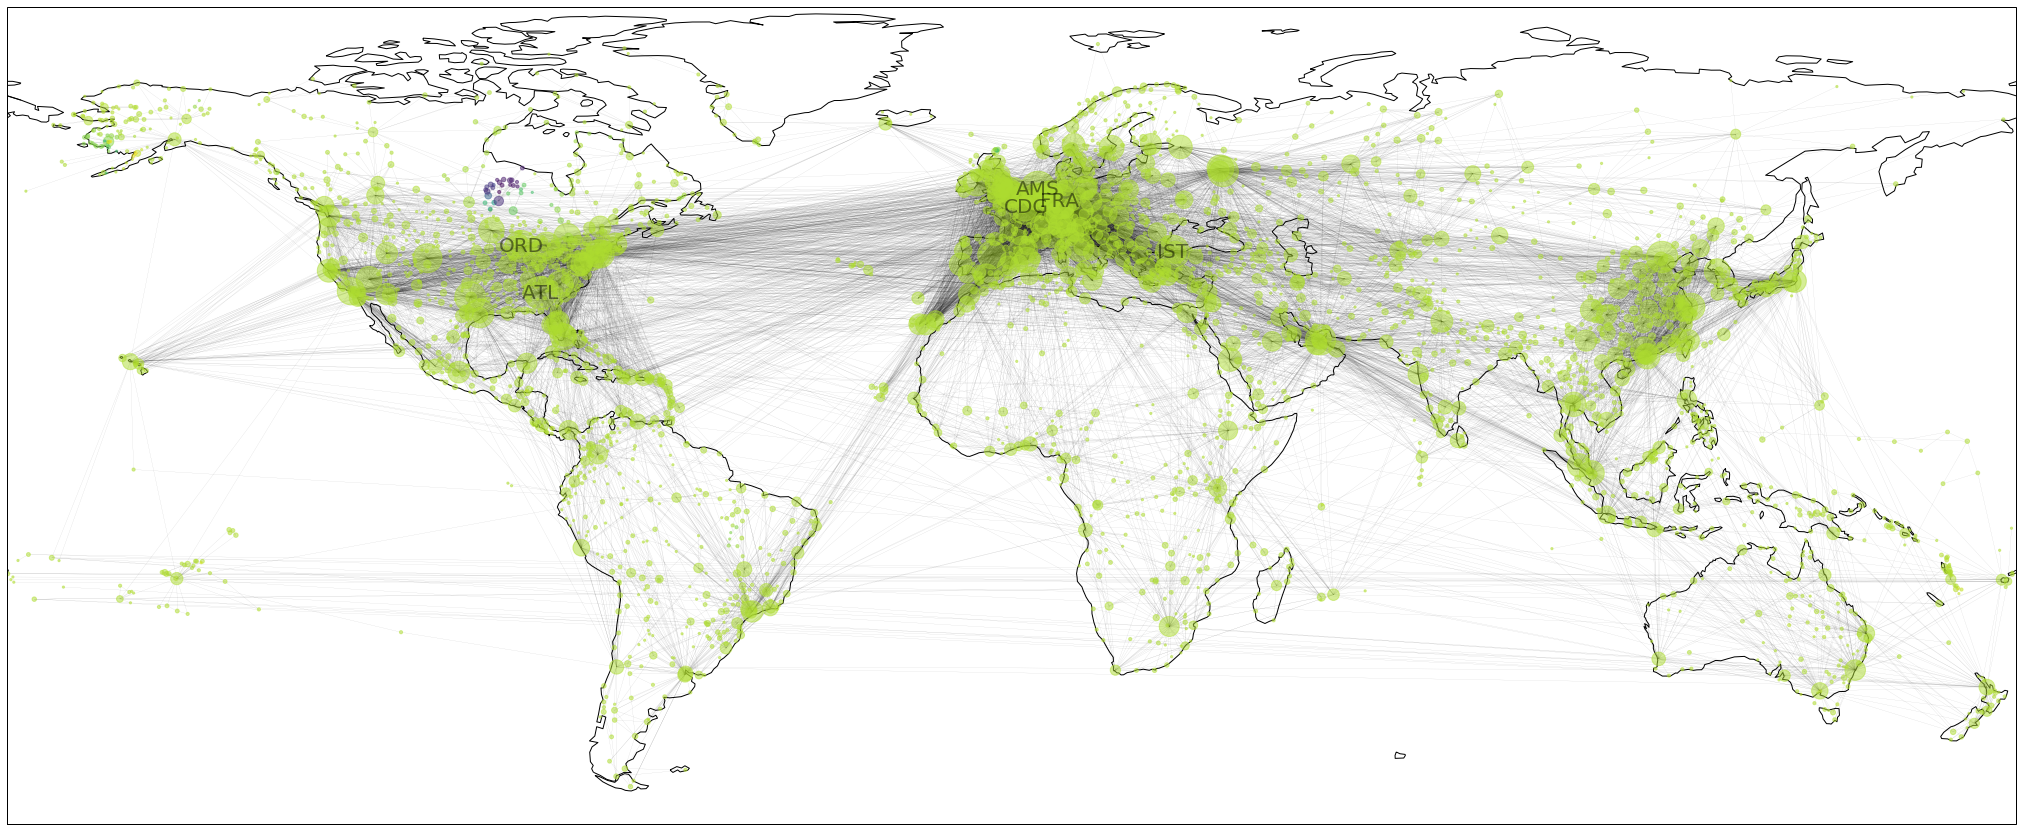

In [75]:
# Map projection
fig, ax = plt.subplots(
    1, 1, figsize=(36, 24),
    subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.coastlines()

# Extent of continental US.
#ax.set_extent([-128, -62, 20, 50])
nx.draw_networkx(largest_cc, ax=ax,
                 font_size=20,
                 alpha=.5,
                 width=.075,
                 node_size=sizes,
                 labels=labels,
                 pos=pos,
                 node_color=U[:,21])

## Flight distance

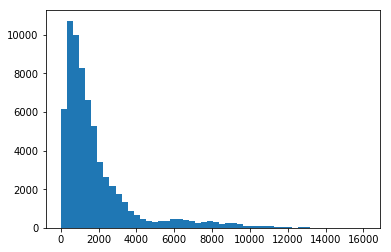

In [32]:
plt.hist(routes_clean['Distance'].values, bins = 50)
plt.show()

## Local/international flights

In [28]:
routes_clean['Source country'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Source airport ID'])].Country.values.item(0), axis = 1)
routes_clean['Destination country'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Destination airport ID'])].Country.values.item(0), axis = 1)

In [29]:
routes_clean['International flight'] = routes_clean.apply(lambda row : not (row['Source country'] == row['Destination country']), axis = 1)

In [30]:
routes_clean['International flight'].value_counts()

True     34222
False    31845
Name: International flight, dtype: int64

In [31]:
collections.Counter(routes_clean['Source country']).most_common(10)

[('United States', 12999),
 ('China', 7995),
 ('United Kingdom', 2634),
 ('Spain', 2525),
 ('Germany', 2328),
 ('France', 1924),
 ('Canada', 1835),
 ('Russia', 1793),
 ('Italy', 1770),
 ('Brazil', 1385)]

In [32]:
collections.Counter(routes_clean['Destination country']).most_common(10)

[('United States', 12994),
 ('China', 7995),
 ('United Kingdom', 2608),
 ('Spain', 2527),
 ('Germany', 2312),
 ('France', 1920),
 ('Canada', 1844),
 ('Russia', 1800),
 ('Italy', 1773),
 ('Brazil', 1382)]

In [33]:
collections.Counter(routes_clean['Source airport']).most_common(10)

[('ATL', 915),
 ('ORD', 556),
 ('CDG', 523),
 ('LHR', 523),
 ('PEK', 520),
 ('LAX', 489),
 ('FRA', 489),
 ('DFW', 469),
 ('JFK', 454),
 ('AMS', 450)]

In [34]:
collections.Counter(routes_clean['Destination airport']).most_common(10)

[('ATL', 911),
 ('ORD', 548),
 ('LHR', 520),
 ('PEK', 519),
 ('CDG', 516),
 ('LAX', 497),
 ('FRA', 485),
 ('DFW', 467),
 ('JFK', 453),
 ('AMS', 446)]

In [35]:
routes_clean[['Source airport', 'Source airport ID', 'Source country']].groupby(['Source airport', 'Source country']).count().sort_values(by = ['Source airport ID'], ascending = False)

,,Source airport ID
Source airport,Source country,
ATL,United States,915
ORD,United States,556
LHR,United Kingdom,523
CDG,France,523
PEK,China,520
LAX,United States,489
FRA,Germany,489
DFW,United States,469
JFK,United States,454


## Laplacian / distance

In [9]:
laplacian = nx.laplacian_matrix(largest_cc).toarray()

In [10]:
laplacian

array([[18, -1,  0, ...,  0,  0,  0],
       [-1, 21, -1, ...,  0,  0,  0],
       [ 0, -1,  7, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  3, -1,  0],
       [ 0,  0,  0, ..., -1,  2,  0],
       [ 0,  0,  0, ...,  0,  0,  1]], dtype=int64)

In [11]:
e, U =  scipy.linalg.eigh(laplacian)

In [12]:
# Indice of the first non-zero eigenvalue
lambda_1_ind = 5

# Laplacian eigenmaps
coords = U[:, lambda_1_ind:lambda_1_ind+2]

def plot_signal(signal):
    """Display nodes of the graph in 2D
    together with the given signal"""
    
    nodes = nx.draw_networkx_nodes(largest_cc, dict(zip(largest_cc.nodes, coords)), node_size=30, node_color=signal)
    plt.xlabel('Value of $\lambda_1$')
    plt.ylabel('Value of $\lambda_2$')
    plt.colorbar(nodes)



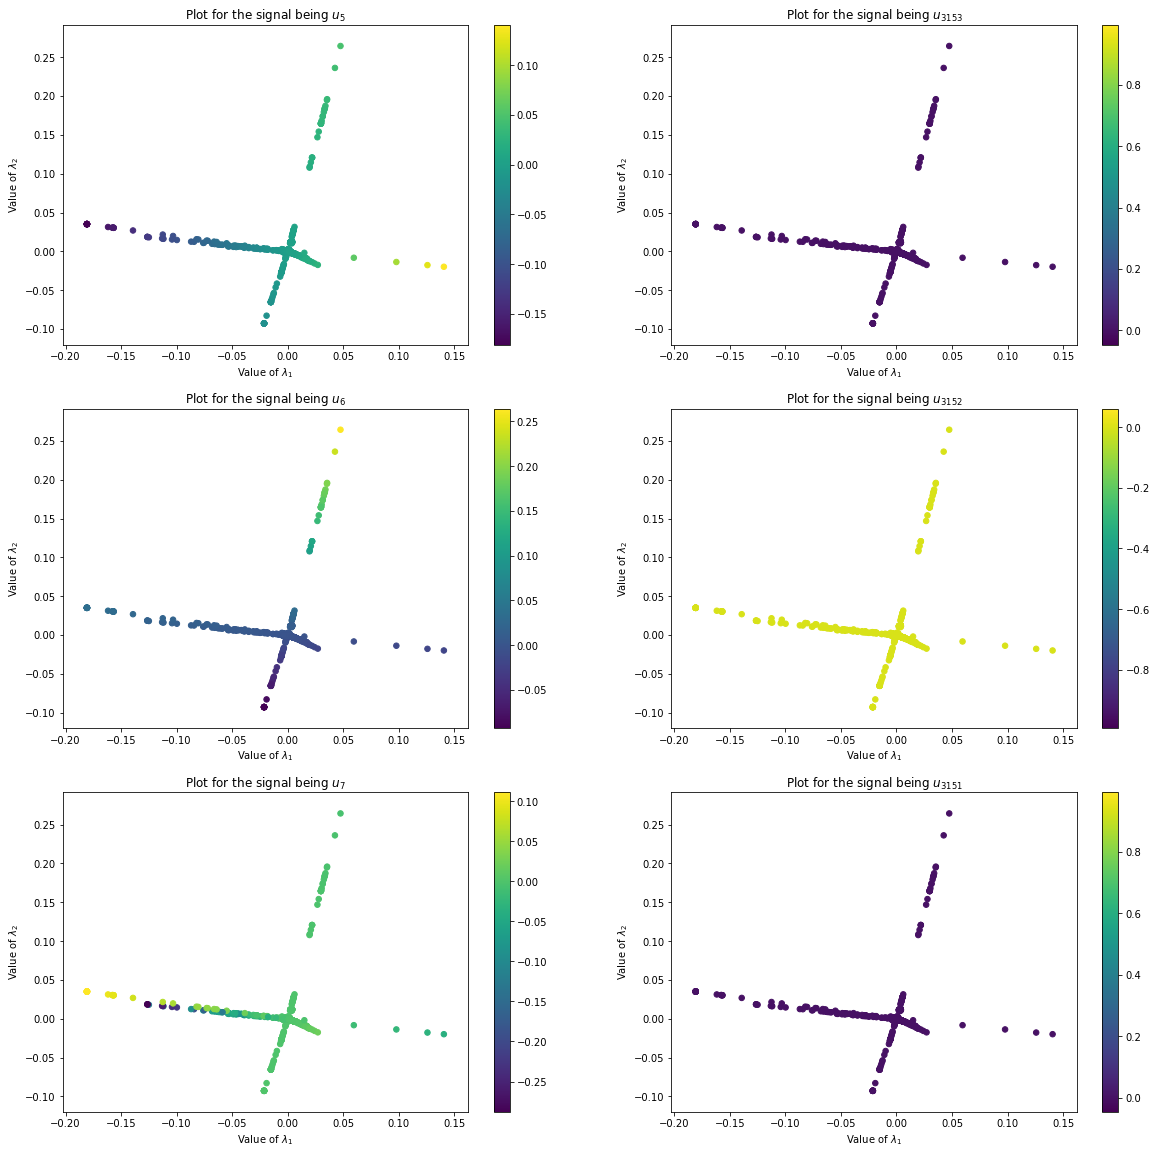

In [13]:
plt.figure(figsize=(20, 20))

# Plot the first 3 Fourier basis vectors
for i in range(3):
    plt.subplot(321 + 2*i)
    plot_signal(U[:, lambda_1_ind + i])
    plt.title('Plot for the signal being $u_{'+ str(lambda_1_ind + i)+'}$')

    # Plot the last 3 Fourier basis vectors
for i in range(3):
    plt.subplot(322 + 2*i)
    plot_signal(U[:, len(largest_cc) - (i + 1)])
    plt.title('Plot for the signal being $u_{'+ str(len(largest_cc) - (i + 1))+'}$')

plt.show()



/home/adirlou/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


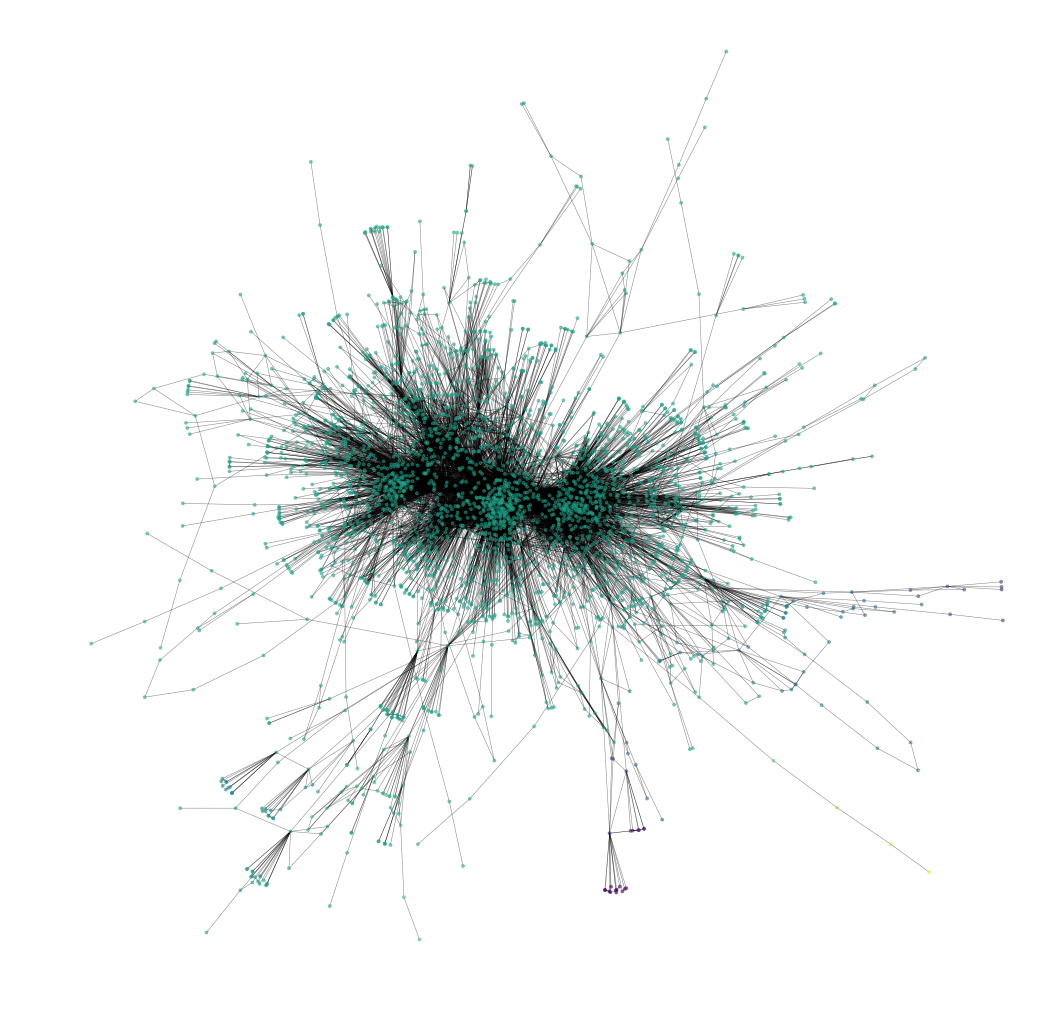

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(18, 18))
nx.draw(largest_cc, node_color = U[:,5], ax=ax, node_size=8, alpha=.5,
                 width=.5, with_labels=False, )
ax.set_axis_off()

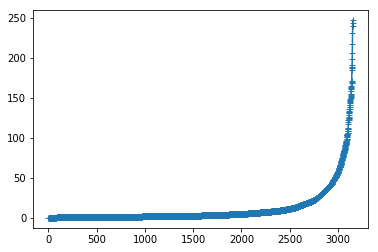

In [14]:
plt.plot(e, '+-')

In [9]:
def plot_community_distr(G):
    
    partition1 = nx.algorithms.community.greedy_modularity_communities(G)
    partition2 = community.best_partition(G)
    
    # Partition1
    mod_classes = np.arange(len(partition1))

    # Partition2
    c = collections.Counter(list(partition2.values()))
    k = c.keys()
    v = c.values()
    
    num_nodes = []
    for set_ in partition1:
        num_nodes.append(len(set_))
    
    plt.figure(figsize=(15,9))
    plt.scatter(mod_classes, num_nodes, label='Clauset-Newman-Moore greedy modularity maximization')
    plt.scatter(k, v, label='Louvain method')
    plt.axis([0, 41, 0, 950])
    plt.xlabel('Modularity class')
    plt.ylabel('Number of nodes')
    plt.xticks(mod_classes)
    plt.legend()
    plt.grid()

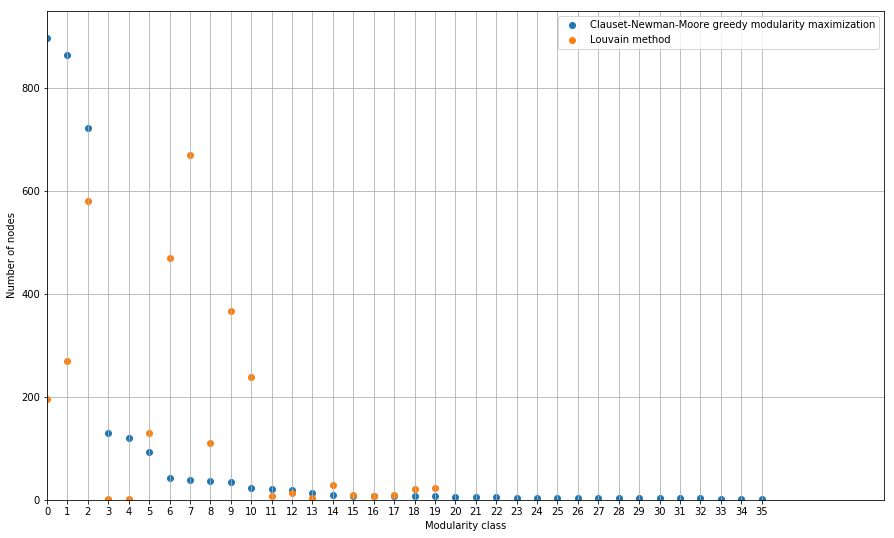

In [10]:
plot_community_distr(largest_cc)

/home/adirlou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row 

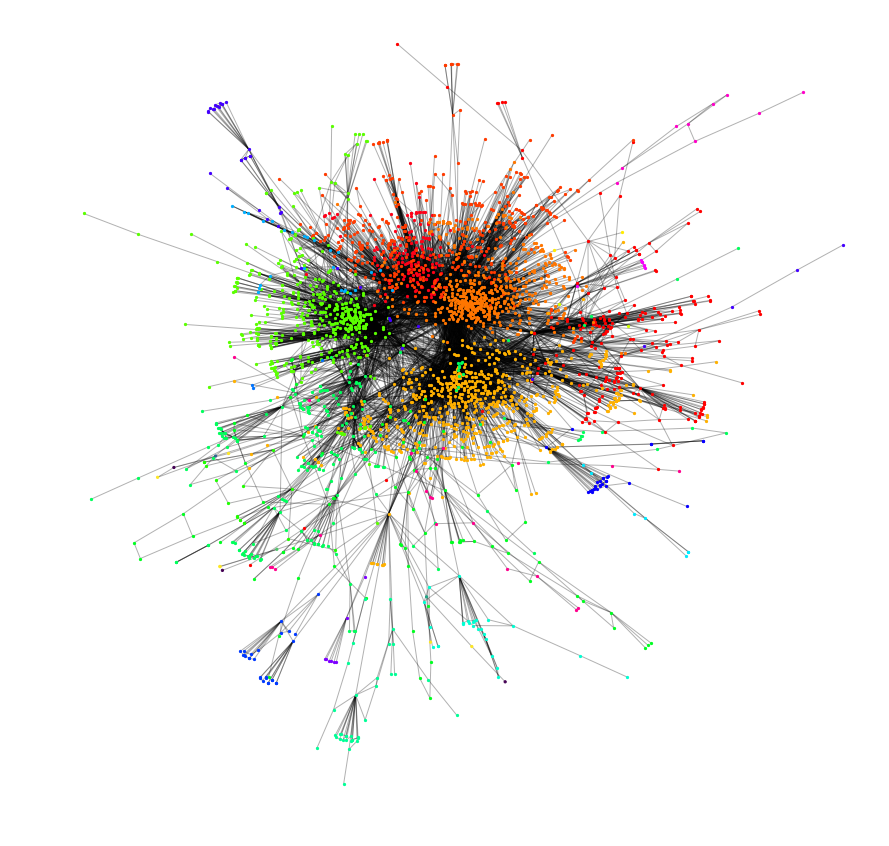

In [22]:
#first compute the best partition
partition = community.best_partition(largest_cc)

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

#drawing
size = float(len(set(partition.values())))

cmap = plt.cm.get_cmap('hsv')
rgba = np.linspace(0.0, 1.0, num=size)

pos = nx.spring_layout(largest_cc)
count = 0
for com in set(partition.values()) :
    count = count + 1
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(largest_cc, pos, list_nodes, ax=ax, node_size=5,
                                node_color=cmap(rgba[count-2]))


nx.draw_networkx_edges(largest_cc, pos, alpha=0.3)
ax.set_axis_off()

In [101]:
cluster = np.load(clustered.npy)

NameError: name 'clustered' is not defined